In [2]:
%load_ext autoreload
%autoreload 2

In [69]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances as euc_dist
from eval_ds import *
from embed_evals import get_knn_score, get_triplet_acc, get_val2train_triplet_acc

In [1]:
from torchvision.datasets import ImageFolder
train_ds = ImageFolder('../datasets/bm/train')
valid_ds = ImageFolder('../datasets/bm/valid')
test_ds = ImageFolder('../datasets/bm/test')
y_train = np.array([y for _, y in train_ds])
y_valid = np.array([y for _, y in valid_ds])
y_test = np.array([y for _, y in test_ds])
ytvs = y_train, y_valid, y_test

/data/anaconda3/envs/hanliu-tutorial/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
p2i_train = pickle.load(open('../datasets/img2idx/bm_train.pkl', 'rb'))
p2i_valid = pickle.load(open('../datasets/img2idx/bm_valid.pkl', 'rb'))
p2i_test = pickle.load(open('../datasets/img2idx/bm_test.pkl', 'rb'))
i2p_train = {v:k for k, v in p2i_train.items()}
i2p_valid = {v:k for k, v in p2i_valid.items()}
i2p_test = {v:k for k, v in p2i_test.items()}

In [6]:
df = pd.read_csv('../datasets/bm_prolific_triplets/ab1-3.results.csv', index_col=0).reset_index(drop=True)
df['ttt'] = df['trips_train'].apply(eval).apply(lambda row: np.array([list(map(lambda i: p2i_train[i], trip)) for trip in row]))
df['vtt'] = df['trips_validtt'].apply(eval).apply(lambda row: np.array([[p2i_valid[trip[0]], p2i_train[trip[1]], p2i_train[trip[2]]] for trip in row]))
df['stt'] = df['trips_testtt'].apply(eval).apply(lambda row: np.array([[p2i_test[trip[0]], p2i_train[trip[1]], p2i_train[trip[2]]] for trip in row]))

In [67]:
def get_apn(trips, ytvs, fold):
    yt, yv, ys = ytvs
    ya = yv if fold == 'validtt' or fold == 'vtt' else ys if fold == 'testtt' or fold == 'stt' else yt
    yp, yn = yt, yt
    a = np.take(ya, trips[:,0])
    p = np.take(yp, trips[:,1])
    n = np.take(yn, trips[:,2])
    return a, p, n

def get_apn_acc(a, p, n):
    apn = (a == p) & (a == n)
    ap_n = (a == p) & (a != n)
    an_p = (a == n) & (a != p)
    a_pn = (a != p) & (p == n)
    # return ap_n.sum() / (ap_n | an_p).sum(), (ap_n | an_p).sum()
    return ap_n.sum() / (ap_n | an_p).sum()

def get_clf_apn(a, p, n):
    apn = (a == p) & (a == n)
    ap_n = (a == p) & (a != n)
    an_p = (a == n) & (a != p)
    a_pn = (a != p) & (p == n)
    return ap_n, (ap_n | an_p)

0.6961666193820799

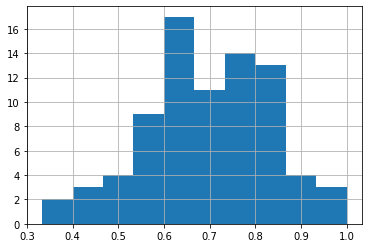

In [68]:
df['tapn'] = df['ttt'].apply(lambda x: get_apn(x, ytvs, fold='ttt'))
df['tapn'].apply(lambda r: get_apn_acc(*r)).hist()
df['tapn'].apply(lambda r: get_apn_acc(*r)).mean()

In [11]:
from itertools import chain
ttt = np.vstack(list(chain(df['ttt'])))
vtt = np.vstack(list(chain(df['vtt'])))
stt = np.vstack(list(chain(df['stt'])))

In [22]:
emb, models, folds, dim = {}, ['RESN', 'TN'], ['train', 'valid', 'test'], 512
for model in models:
    for fold in folds:
        if model not in emb:
            emb[model] = {}
        emb[model][fold] = pickle.load(open(f'../embeds/bm/prolific/{model}_{fold}_emb{dim}.pkl', 'rb'))

In [42]:
r_train, r_test = emb['RESN']['train'], emb['RESN']['test']
t_train, t_test = emb['TN']['train'], emb['TN']['test']
rdst = euc_dist(r_test, r_train)
tdst = euc_dist(t_test, t_train)

In [26]:
rnn1c = pickle.load(open('../examples/nn_1class/bm_RESN.pkl', 'rb'))
mnn1c = pickle.load(open('../examples/nn_1class/bm_MTL.pkl', 'rb'))

In [27]:
def get_path(nn_mat, i2p_test, i2p_train):
    path_mat = np.zeros_like(nn_mat).astype(str)
    path_mat[:,0] = np.vectorize(i2p_test.get)(nn_mat[:,0])
    path_mat[:,1:] = np.vectorize(i2p_train.get)(nn_mat[:,1:])
    return path_mat

In [28]:
mat = np.vstack([np.arange(len(y_test)), rnn1c, mnn1c]).T
# mat = get_path(mat, i2p_test, i2p_train)
# pickle.dump(mat, open('../examples/nn_1class/bm_RESN_MTL.pkl', 'wb'))

In [65]:
(get_ds_choice(rdst, stt) == 0).mean(), get_val2train_triplet_acc(r_train, r_test, stt)

(0.6025, 0.6025)

In [66]:
(get_ds_choice(tdst, stt) == 0).mean(), get_val2train_triplet_acc(t_train, t_test, stt)

(0.6775, 0.6775)

In [74]:
rds = get_ds(rdst, y_test, y_train)
rchoice = get_ds_choice(rdst, rds)
r1nnacc = eval_ds_choice(rchoice, rds, y_test, y_train).mean()
r1nnacc, get_knn_score(r_train, y_train, r_test, y_valid)

(0.875, 0.875)

In [75]:
tds = get_ds(tdst, y_test, y_train)
tchoice = get_ds_choice(tdst, tds)
t1nnacc = eval_ds_choice(tchoice, tds, y_test, y_train).mean()
t1nnacc, get_knn_score(t_train, y_train, t_test, y_valid)

(0.75, 0.75)